In [1]:
import pandas as pd
import seaborn as sns


# Enable multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
states = ['NSW','VIC','SA','QLD']

In [3]:
DATA_PATH = "../../data/UNSW-PROJECT-DATA/"
datafile = "demand_pv_temp_forecast_timefeatures_hols.csv"

# Load the merged demand_pv_temp_forecast merged file. This already has MEAN forecast per demand timepoint (ie: all forecasts for that timepoint averaged)
demand = pd.read_csv(DATA_PATH+datafile)
demand['DATETIME'] = pd.to_datetime(demand['DATETIME'])
demand['SUNRISE'] = pd.to_datetime(demand['SUNRISE'])
demand['SUNSET'] = pd.to_datetime(demand['SUNSET'])

# Rename the FORECAST demand column MEANFORECAST to indicate it has been processed and avoid confusion
demand['MEANFORECAST'] = demand['FORECASTDEMAND']
demand = demand.drop(['FORECASTDEMAND'], axis=1)


In [4]:
demand.shape
demand.isna().sum()
demand['DATETIME'].min()
demand['DATETIME'].max()

(726195, 17)

STATE                0
DATETIME             0
TOTALDEMAND          0
POWER           513681
LOCATION             0
TEMPERATURE         12
Weekday              0
Quarter              0
Month                0
Season               0
Day                  0
Year                 0
SUNRISE              0
SUNSET               0
DAYTYPE              0
HOLIDAY              0
MEANFORECAST    308351
dtype: int64

Timestamp('2010-01-01 00:00:00')

Timestamp('2021-03-18 00:00:00')

PV data is not available for the entire data period. Define where the PV data begins for each state

In [5]:
demand[demand['POWER'].notna()].groupby(by='STATE')['DATETIME'].min()

STATE
NSW   2018-03-06 09:30:00
QLD   2018-03-06 09:30:00
SA    2018-03-06 09:30:00
VIC   2018-03-06 09:30:00
Name: DATETIME, dtype: datetime64[ns]

Define a new dataframe containing only data for the range containing PV data (pv)

In [4]:
#pv = demand[demand['DATETIME'] >= '20180306']
pv = demand[demand['POWER'].notna()]
pv.DATETIME = pd.to_datetime(pv.DATETIME)
pv.shape
pv.isna().sum()

/var/folders/h8/db9ggz8548ddft2yd4yw4kzh0000gq/T/ipykernel_26825/1298575471.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv.DATETIME = pd.to_datetime(pv.DATETIME)


(212514, 17)

STATE           0
DATETIME        0
TOTALDEMAND     0
POWER           0
LOCATION        0
TEMPERATURE     6
Weekday         0
Quarter         0
Month           0
Season          0
Day             0
Year            0
SUNRISE         0
SUNSET          0
DAYTYPE         0
HOLIDAY         0
MEANFORECAST    0
dtype: int64

# Distribution by state of energy demand over PV-aware period


<AxesSubplot:xlabel='TOTALDEMAND', ylabel='Density'>

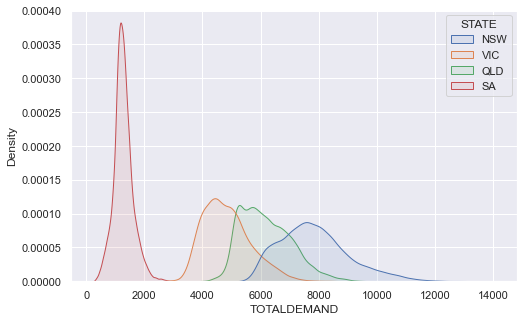

In [5]:
sns.set(rc={"figure.figsize": (8,5)})
sns.kdeplot(data=pv[pv['POWER'].notna()], x='TOTALDEMAND', hue='STATE', fill=True, alpha=0.1)

# Daily distribution of power demand - NSW and VIC

<AxesSubplot:xlabel='Weekday', ylabel='TOTALDEMAND'>

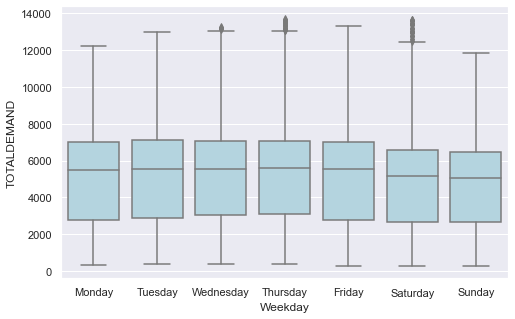

In [8]:
sns.boxplot(data=pv, x=pv['Weekday'], y='TOTALDEMAND', color='lightblue',order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

In [ ]:
# Distribution of temperatures over PV-aware period

<AxesSubplot:xlabel='TEMPERATURE', ylabel='Density'>

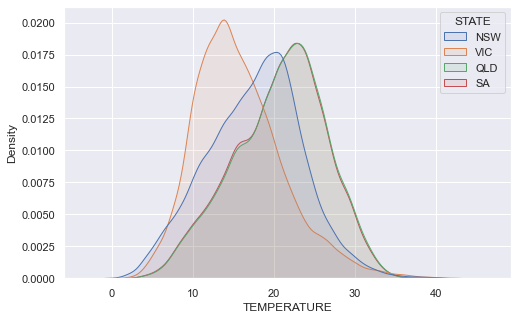

In [6]:
sns.set(rc={"figure.figsize": (8,5)})
sns.kdeplot(data=pv[pv['TEMPERATURE'].notna()], x='TEMPERATURE', hue='STATE', fill=True, alpha=0.1)

In [7]:
# Perform calculations necessary to plot a normalised 'typical daily TOTALDEMAND profile'
# First calculate the max_daily total demand. Then normalise each timepoint against this
max_demand = pv.groupby([pv['DATETIME'].dt.date, 'STATE']).aggregate({'TOTALDEMAND':max})
max_demand = max_demand.rename(columns={'TOTALDEMAND':'Maximum daily energy demand (MW)'})

demand_merge = pd.merge(pv, max_demand, left_on=[pv.DATETIME.dt.date, 'STATE'], right_on=['DATETIME','STATE'])
demand_merge['NORMALISED'] = demand_merge['TOTALDEMAND'] / demand_merge['Maximum daily energy demand (MW)']
demand_merge['DATETIME'] = pd.to_datetime(demand_merge['DATETIME'])
demand_merge.rename(columns={'NORMALISED':'Normalised energy demand'}, inplace=True)



## Daily maximum energy demand plotted over time

<AxesSubplot:xlabel='DATETIME', ylabel='Maximum daily energy demand (MW)'>

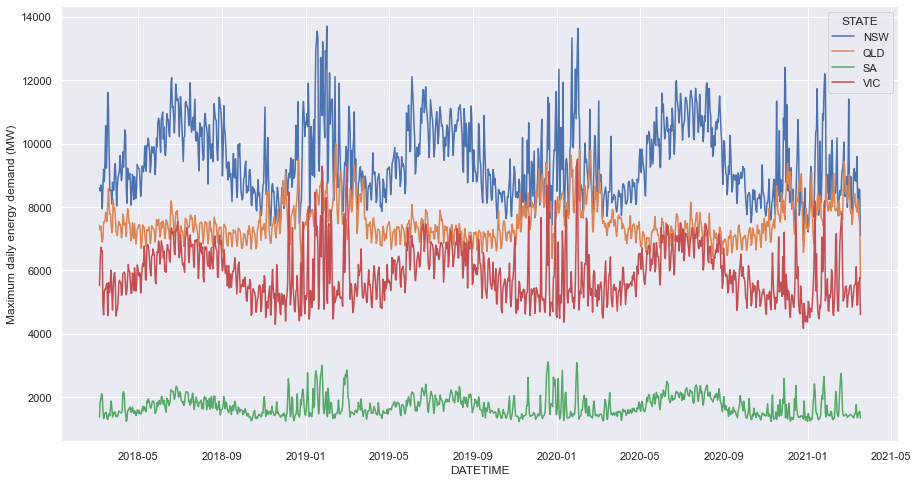

In [42]:
sns.set(rc={"figure.figsize": (15,8)})
sns.lineplot(data=max_demand, x='DATETIME', y='Maximum daily energy demand (MW)',hue='STATE')


In [9]:
## Smoothed plot of maximum daily energy demand
max_demand['Smoothed maximum daily energy demand (MW)'] = max_demand.groupby(by='STATE')['Maximum daily energy demand (MW)'].apply(lambda x: x.rolling(3).mean())

<AxesSubplot:xlabel='DATETIME', ylabel='Smoothed maximum daily energy demand (MW)'>

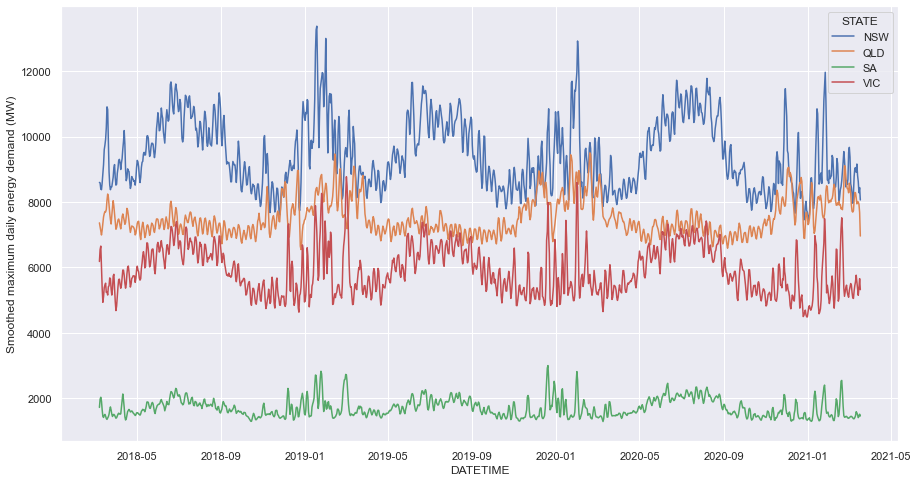

In [10]:
sns.lineplot(data=max_demand, x='DATETIME', y='Smoothed maximum daily energy demand (MW)',hue='STATE')

In [14]:
demand_merge.columns

Index(['STATE', 'DATETIME', 'TOTALDEMAND', 'POWER', 'LOCATION', 'TEMPERATURE',
       'Weekday', 'Quarter', 'Month', 'Season', 'Day', 'Year', 'SUNRISE',
       'SUNSET', 'DAYTYPE', 'HOLIDAY', 'MEANFORECAST',
       'Maximum daily energy demand (MW)', 'Normalised energy demand'],
      dtype='object')

/var/folders/h8/db9ggz8548ddft2yd4yw4kzh0000gq/T/ipykernel_26825/3769140782.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  daily_energy_plot.set_xticklabels(labels=timelist, rotation=45)


[Text(0, 0, '00:00:00'),
 Text(1, 0, '00:30:00'),
 Text(2, 0, '01:00:00'),
 Text(3, 0, '01:30:00'),
 Text(4, 0, '02:00:00'),
 Text(5, 0, '02:30:00'),
 Text(6, 0, '03:00:00'),
 Text(7, 0, '03:30:00'),
 Text(8, 0, '04:00:00'),
 Text(9, 0, '04:30:00'),
 Text(10, 0, '05:00:00'),
 Text(11, 0, '05:30:00'),
 Text(12, 0, '06:00:00'),
 Text(13, 0, '06:30:00'),
 Text(14, 0, '07:00:00'),
 Text(15, 0, '07:30:00'),
 Text(16, 0, '08:00:00'),
 Text(17, 0, '08:30:00'),
 Text(18, 0, '09:00:00'),
 Text(19, 0, '09:30:00'),
 Text(20, 0, '10:00:00'),
 Text(21, 0, '10:30:00'),
 Text(22, 0, '11:00:00'),
 Text(23, 0, '11:30:00'),
 Text(24, 0, '12:00:00'),
 Text(25, 0, '12:30:00'),
 Text(26, 0, '13:00:00'),
 Text(27, 0, '13:30:00'),
 Text(28, 0, '14:00:00'),
 Text(29, 0, '14:30:00'),
 Text(30, 0, '15:00:00'),
 Text(31, 0, '15:30:00'),
 Text(32, 0, '16:00:00'),
 Text(33, 0, '16:30:00'),
 Text(34, 0, '17:00:00'),
 Text(35, 0, '17:30:00'),
 Text(36, 0, '18:00:00'),
 Text(37, 0, '18:30:00'),
 Text(38, 0, '19:00:00

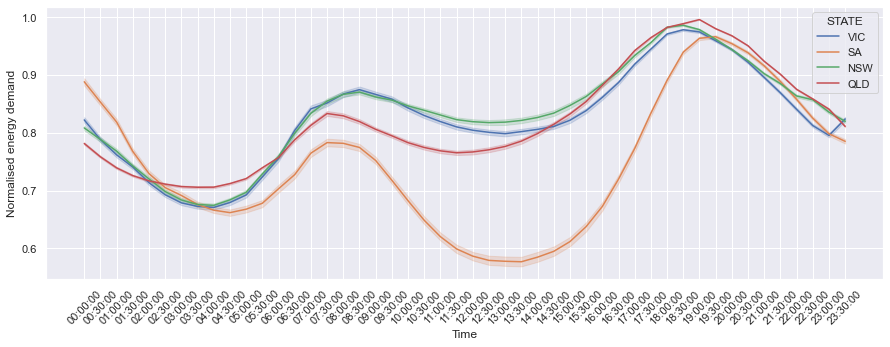

In [11]:
demand_merge['Time'] = demand_merge['DATETIME'].dt.time
demand_merge = demand_merge.sort_values(by='Time')

demand_merge['Time'] = demand_merge['Time'].astype(str)
timelist = demand_merge['Time'].unique()

sns.set(rc={"figure.figsize": (15,5)})
daily_energy_plot = sns.lineplot(data=demand_merge, x='Time', y='Normalised energy demand', hue='STATE',ci=95, estimator='mean')
daily_energy_plot.set_xticklabels(labels=timelist, rotation=45)
ax1 = daily_energy_plot.axes


In [12]:
#import statsmodels.api as sm

# PV production distribution per state
# Calculate the maximum daily POWER for each state
max_power = pv.groupby([pv['DATETIME'].dt.date, 'STATE']).aggregate({'POWER':max})
max_power = max_power.rename(columns={'POWER':'Maximum daily PV power (MW)'})
max_power = max_power.reset_index()



max_power.columns
# Smooth the max daily power values
#x = max_power
#max_power['SMOOTH'] = sm.nonparametric.lowess(max_power['POWER'], max_power['DATETIME'].astype(str), frac=1./3, it=3)

#max_nsw_power = pv[pv['STATE'] == 'NSW'].groupby(pv['DATETIME'].dt.date).aggregate({'POWER':max})

# Set the index type to datetime
#max_nsw_power.index = pd.to_datetime(max_nsw_power.index)


Index(['DATETIME', 'STATE', 'Maximum daily PV power (MW)'], dtype='object')

In [168]:

max_power.index

RangeIndex(start=0, stop=4436, step=1)

## Plot the maximum daily PV output over the data period to expose seasonal trends and long-term PV output trends
This graph ideally needs a smoothed line plotted over the top too

<AxesSubplot:xlabel='DATETIME', ylabel='Maximum daily PV power (MW)'>

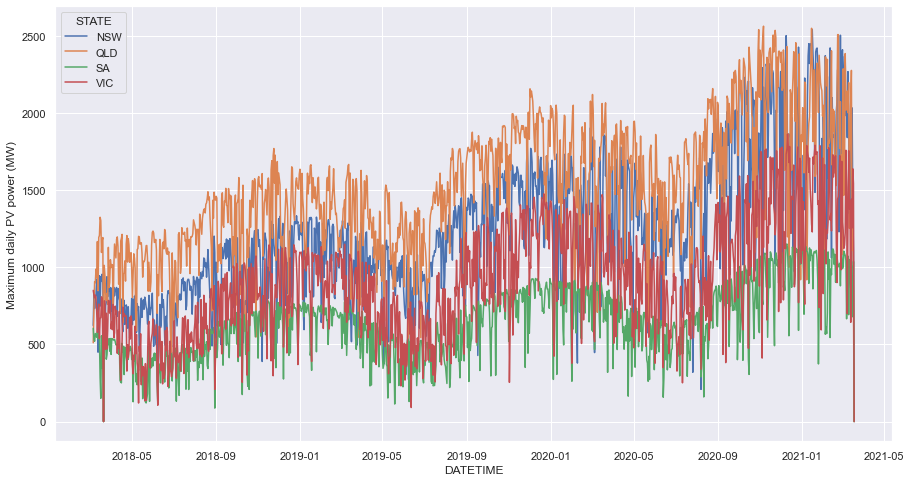

In [13]:
# Plot the maximum daily PV output
sns.set(rc={"figure.figsize": (15,8)})
#sns.lineplot(data=pv.groupby([pv['DATETIME'].dt.date, 'STATE']).aggregate({'POWER':max}), x='DATETIME', y='POWER',hue='STATE')
sns.lineplot(data=max_power, x='DATETIME', y='Maximum daily PV power (MW)',hue='STATE')

In [19]:
max_power['Smoothed maximum daily PV output (MW)'] = max_power.groupby(by='STATE')['Maximum daily PV power (MW)'].apply(lambda x: x.rolling(30).mean())

<AxesSubplot:xlabel='DATETIME', ylabel='Smoothed maximum daily PV output (MW)'>

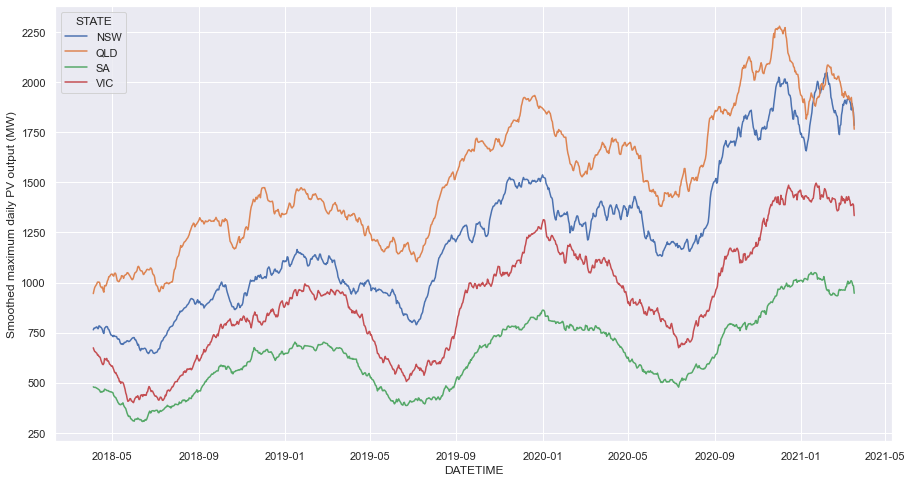

In [20]:
sns.lineplot(data=max_power, x='DATETIME', y='Smoothed maximum daily PV output (MW)',hue='STATE')

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
pv_seasonal = max_power[max_power['STATE'] == 'NSW'][['DATETIME','Smoothed maximum daily PV output (MW)']]
pv_seasonal['DATETIME'] = pd.to_datetime(pv_seasonal['DATETIME'])
pv_seasonal.set_index('DATETIME', inplace=True)
pv_seasonal.dropna(inplace=True)

KeyError: "['Smoothed maximum daily PV output (MW)'] not in index"

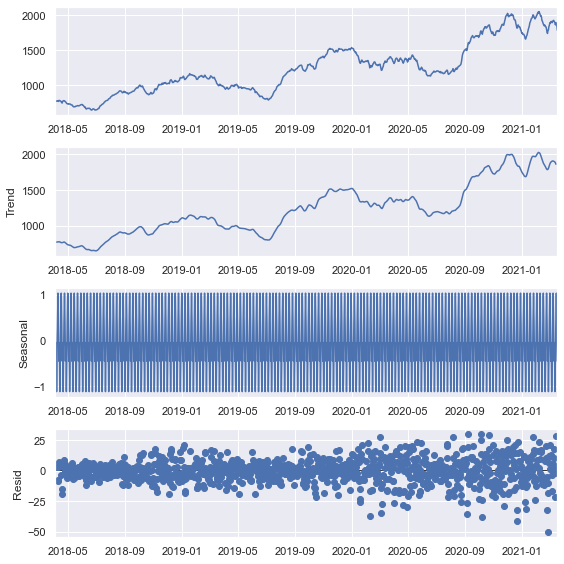

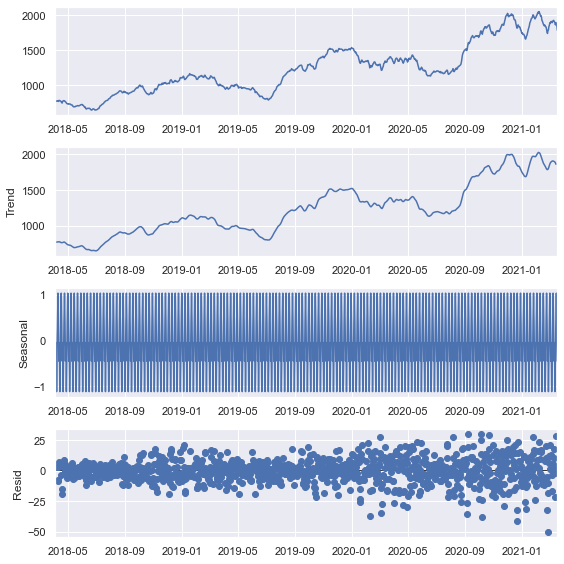

In [143]:




decompose = seasonal_decompose(pv_seasonal, model="additive")

decompose.plot()

In [15]:
# Plot a combined daily PV output map (by state)
# First group by time of day and state. Then calculate each POWER relative to the maximum of each day
#pv.groupby([pv['DATETIME'].dt.date, 'STATE']).aggregate({'POWER':max})
pv_merge = pd.merge(pv, max_power, left_on=[pv.DATETIME.dt.date, 'STATE'], right_on=['DATETIME','STATE'])
pv_merge['NORMALISED'] = pv_merge['POWER'] / pv_merge['Maximum daily PV power (MW)']
pv_merge['DATETIME'] = pd.to_datetime(pv_merge['DATETIME'])
pv_merge.rename(columns={'NORMALISED':'Normalised PV power output'}, inplace=True)



In [16]:
pv_merge['Time'] = pv_merge['DATETIME_x'].dt.time
pv_merge = pv_merge.sort_values(by='Time')

pv_merge['Time'] = pv_merge['Time'].astype(str)
timelist = pv_merge['Time'].unique()


/var/folders/h8/db9ggz8548ddft2yd4yw4kzh0000gq/T/ipykernel_26825/1409122577.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  daily_pv_plot.set_xticklabels(labels=timelist, rotation=45)


[Text(0, 0, '00:00:00'),
 Text(1, 0, '00:30:00'),
 Text(2, 0, '01:00:00'),
 Text(3, 0, '01:30:00'),
 Text(4, 0, '02:00:00'),
 Text(5, 0, '02:30:00'),
 Text(6, 0, '03:00:00'),
 Text(7, 0, '03:30:00'),
 Text(8, 0, '04:00:00'),
 Text(9, 0, '04:30:00'),
 Text(10, 0, '05:00:00'),
 Text(11, 0, '05:30:00'),
 Text(12, 0, '06:00:00'),
 Text(13, 0, '06:30:00'),
 Text(14, 0, '07:00:00'),
 Text(15, 0, '07:30:00'),
 Text(16, 0, '08:00:00'),
 Text(17, 0, '08:30:00'),
 Text(18, 0, '09:00:00'),
 Text(19, 0, '09:30:00'),
 Text(20, 0, '10:00:00'),
 Text(21, 0, '10:30:00'),
 Text(22, 0, '11:00:00'),
 Text(23, 0, '11:30:00'),
 Text(24, 0, '12:00:00'),
 Text(25, 0, '12:30:00'),
 Text(26, 0, '13:00:00'),
 Text(27, 0, '13:30:00'),
 Text(28, 0, '14:00:00'),
 Text(29, 0, '14:30:00'),
 Text(30, 0, '15:00:00'),
 Text(31, 0, '15:30:00'),
 Text(32, 0, '16:00:00'),
 Text(33, 0, '16:30:00'),
 Text(34, 0, '17:00:00'),
 Text(35, 0, '17:30:00'),
 Text(36, 0, '18:00:00'),
 Text(37, 0, '18:30:00'),
 Text(38, 0, '19:00:00

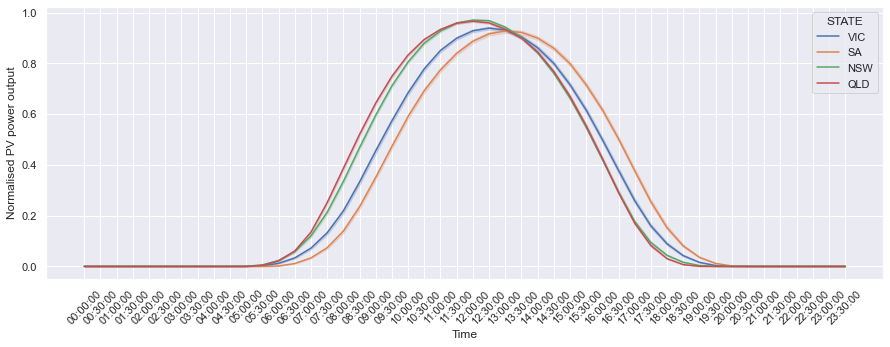

In [17]:
sns.set(rc={"figure.figsize": (15,5)})
daily_pv_plot = sns.lineplot(data=pv_merge, x='Time', y='Normalised PV power output', hue='STATE',ci=95, estimator='mean')
daily_pv_plot.set_xticklabels(labels=timelist, rotation=45)
ax1 = daily_pv_plot.axes

In [23]:
pv_merge.columns

Index(['DATETIME', 'STATE', 'DATETIME_x', 'TOTALDEMAND', 'POWER', 'LOCATION',
       'TEMPERATURE', 'Weekday', 'Quarter', 'Month', 'Season', 'Day', 'Year',
       'SUNRISE', 'SUNSET', 'DAYTYPE', 'HOLIDAY', 'MEANFORECAST', 'DATETIME_y',
       'Maximum daily PV power (MW)', 'Smoothed maximum daily PV output (MW)',
       'Normalised PV power output', 'Time'],
      dtype='object')

In [37]:
pv_merge['POWER+TOTALDEMAND'] = pv_merge['TOTALDEMAND'] + pv_merge['POWER']

pv_sa = pv_merge[pv_merge['STATE'] == 'SA']

melted = pd.melt(pv_sa, id_vars=['Time'], value_vars=['POWER','TOTALDEMAND','POWER+TOTALDEMAND'])
melted.columns

#melt = melt.melt(id_vars=['Time'], value_vars=['TOTALDEMAND','POWER'])

Index(['Time', 'variable', 'value'], dtype='object')

/var/folders/h8/db9ggz8548ddft2yd4yw4kzh0000gq/T/ipykernel_26825/577210304.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  demand_pv_plot.set_xticklabels(labels=timelist, rotation=45)


[Text(0, 0, '00:00:00'),
 Text(1, 0, '00:30:00'),
 Text(2, 0, '01:00:00'),
 Text(3, 0, '01:30:00'),
 Text(4, 0, '02:00:00'),
 Text(5, 0, '02:30:00'),
 Text(6, 0, '03:00:00'),
 Text(7, 0, '03:30:00'),
 Text(8, 0, '04:00:00'),
 Text(9, 0, '04:30:00'),
 Text(10, 0, '05:00:00'),
 Text(11, 0, '05:30:00'),
 Text(12, 0, '06:00:00'),
 Text(13, 0, '06:30:00'),
 Text(14, 0, '07:00:00'),
 Text(15, 0, '07:30:00'),
 Text(16, 0, '08:00:00'),
 Text(17, 0, '08:30:00'),
 Text(18, 0, '09:00:00'),
 Text(19, 0, '09:30:00'),
 Text(20, 0, '10:00:00'),
 Text(21, 0, '10:30:00'),
 Text(22, 0, '11:00:00'),
 Text(23, 0, '11:30:00'),
 Text(24, 0, '12:00:00'),
 Text(25, 0, '12:30:00'),
 Text(26, 0, '13:00:00'),
 Text(27, 0, '13:30:00'),
 Text(28, 0, '14:00:00'),
 Text(29, 0, '14:30:00'),
 Text(30, 0, '15:00:00'),
 Text(31, 0, '15:30:00'),
 Text(32, 0, '16:00:00'),
 Text(33, 0, '16:30:00'),
 Text(34, 0, '17:00:00'),
 Text(35, 0, '17:30:00'),
 Text(36, 0, '18:00:00'),
 Text(37, 0, '18:30:00'),
 Text(38, 0, '19:00:00

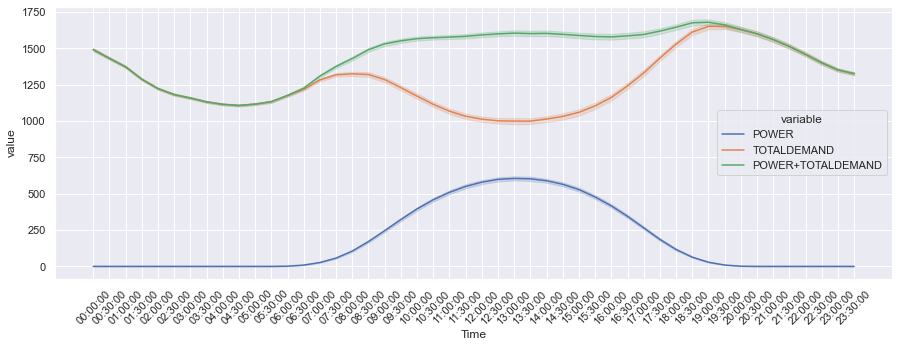

In [38]:
demand_pv_plot = sns.lineplot(data=melted, x='Time', y='value', hue='variable',ci=95, estimator='mean')
demand_pv_plot.set_xticklabels(labels=timelist, rotation=45)
ax1 = demand_pv_plot.axes

Generate a summed POWER+TOTALDEMAND curve for all states to show the consistency of this approach

/var/folders/h8/db9ggz8548ddft2yd4yw4kzh0000gq/T/ipykernel_26825/2069623551.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  demand_pv_plot.set_xticklabels(labels=timelist, rotation=45)


[Text(0, 0, '00:00:00'),
 Text(1, 0, '00:30:00'),
 Text(2, 0, '01:00:00'),
 Text(3, 0, '01:30:00'),
 Text(4, 0, '02:00:00'),
 Text(5, 0, '02:30:00'),
 Text(6, 0, '03:00:00'),
 Text(7, 0, '03:30:00'),
 Text(8, 0, '04:00:00'),
 Text(9, 0, '04:30:00'),
 Text(10, 0, '05:00:00'),
 Text(11, 0, '05:30:00'),
 Text(12, 0, '06:00:00'),
 Text(13, 0, '06:30:00'),
 Text(14, 0, '07:00:00'),
 Text(15, 0, '07:30:00'),
 Text(16, 0, '08:00:00'),
 Text(17, 0, '08:30:00'),
 Text(18, 0, '09:00:00'),
 Text(19, 0, '09:30:00'),
 Text(20, 0, '10:00:00'),
 Text(21, 0, '10:30:00'),
 Text(22, 0, '11:00:00'),
 Text(23, 0, '11:30:00'),
 Text(24, 0, '12:00:00'),
 Text(25, 0, '12:30:00'),
 Text(26, 0, '13:00:00'),
 Text(27, 0, '13:30:00'),
 Text(28, 0, '14:00:00'),
 Text(29, 0, '14:30:00'),
 Text(30, 0, '15:00:00'),
 Text(31, 0, '15:30:00'),
 Text(32, 0, '16:00:00'),
 Text(33, 0, '16:30:00'),
 Text(34, 0, '17:00:00'),
 Text(35, 0, '17:30:00'),
 Text(36, 0, '18:00:00'),
 Text(37, 0, '18:30:00'),
 Text(38, 0, '19:00:00

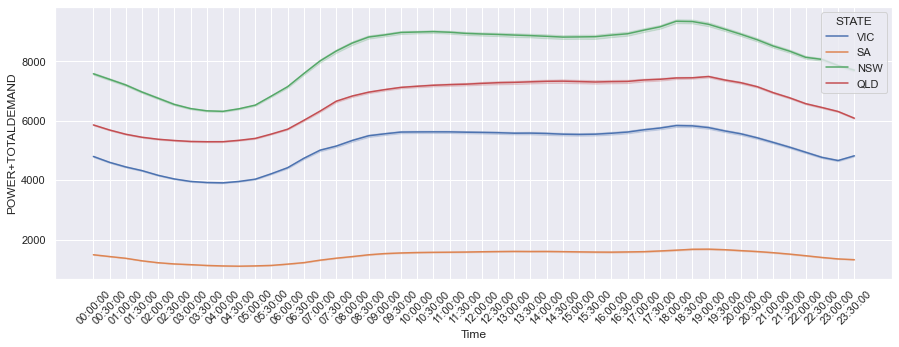

In [39]:
demand_pv_plot = sns.lineplot(data=pv_merge, x='Time', y='POWER+TOTALDEMAND', hue='STATE',ci=95, estimator='mean')
demand_pv_plot.set_xticklabels(labels=timelist, rotation=45)
ax1 = demand_pv_plot.axes

In [84]:
pv_merge[(pv_merge['STATE'] == 'SA') & (pv_merge['Normalised PV power output'] == 1)]

,DATETIME,STATE,DATETIME_x,TOTALDEMAND,POWER,LOCATION,TEMPERATURE,Weekday,Quarter,Month,...,Year,SUNRISE,SUNSET,DAYTYPE,HOLIDAY,MEANFORECAST,DATETIME_y,Maximum daily PV power (MW),Normalised PV power output,Time
121473,2019-11-29,SA,2019-11-29 09:30:00,1103.59,443.374,Adelaide (Kent Town),27.4,Friday,4,11,...,2019,2019-11-29 05:25:00,2019-11-29 19:42:00,Day,False,1037.692619,2019-11-29,443.374,1.0,09:30:00
102370,2019-08-22,SA,2019-08-22 10:00:00,1365.82,283.416,Adelaide (Kent Town),21.4,Thursday,3,8,...,2019,2019-08-22 07:18:00,2019-08-22 18:19:00,Day,False,1437.794651,2019-08-22,283.416,1.0,10:00:00
202594,2021-01-25,SA,2021-01-25 10:00:00,1748.33,373.698,Adelaide (Kent Town),26.3,Monday,1,1,...,2021,2021-01-25 05:58:00,2021-01-25 19:58:00,Day,False,2057.791860,2021-01-25,373.698,1.0,10:00:00
36186,2018-09-11,SA,2018-09-11 10:00:00,917.24,365.558,Adelaide (Kent Town),21.5,Tuesday,3,9,...,2018,2018-09-11 06:51:00,2018-09-11 18:33:00,Day,False,942.426512,2018-09-11,365.558,1.0,10:00:00
204706,2021-02-05,SA,2021-02-05 10:00:00,833.81,612.776,Adelaide (Kent Town),27.3,Friday,1,2,...,2021,2021-02-05 06:09:00,2021-02-05 19:50:00,Day,False,871.641860,2021-02-05,612.776,1.0,10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50982,2018-11-27,SA,2018-11-27 16:00:00,1051.06,349.366,Adelaide (Kent Town),26.7,Tuesday,4,11,...,2018,2018-11-27 05:26:00,2018-11-27 19:40:00,Day,False,1135.413818,2018-11-27,349.366,1.0,16:00:00
129407,2020-01-10,SA,2020-01-10 16:30:00,1104.00,305.869,Adelaide (Kent Town),29.3,Friday,1,1,...,2020,2020-01-10 05:42:00,2020-01-10 20:03:00,Day,False,1250.750536,2020-01-10,305.869,1.0,16:30:00
61012,2019-01-18,SA,2019-01-18 17:00:00,1315.42,332.052,Adelaide (Kent Town),29.1,Friday,1,1,...,2019,2019-01-18 05:50:00,2019-01-18 20:01:00,Day,False,1643.543684,2019-01-18,332.052,1.0,17:00:00
53144,2018-12-08,SA,2018-12-08 17:00:00,1077.36,275.988,Adelaide (Kent Town),24.9,Saturday,4,12,...,2018,2018-12-08 05:25:00,2018-12-08 19:50:00,Day,False,1276.310877,2018-12-08,275.988,1.0,17:00:00


<AxesSubplot:xlabel='Maximum daily PV power (MW)', ylabel='Density'>

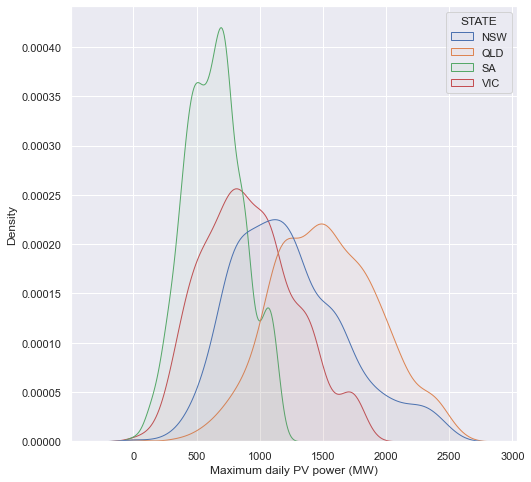

In [141]:
sns.set(rc={"figure.figsize": (8,8)})
sns.kdeplot(data=max_power[max_power['Maximum daily PV power (MW)'].notna()], x='Maximum daily PV power (MW)', hue='STATE', fill=True, alpha=0.05)

# Energy demand trend by state 
# This needs to be re-done as max daily demand I think


<AxesSubplot:xlabel='DATETIME', ylabel='TOTALDEMAND'>

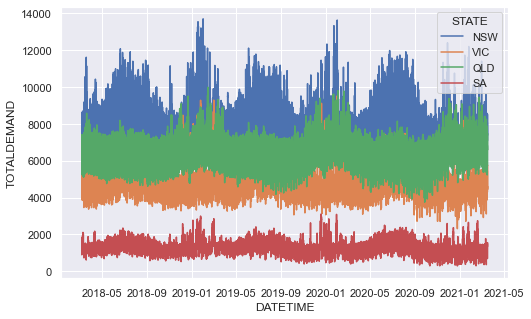

In [62]:
sns.lineplot(data=pv[pv['POWER'].notna()], x='DATETIME', y='TOTALDEMAND',hue='STATE')

# Analysis of the nominated project test set (ie: 1st January 2021 - 31st January 2021)
The month of January 2021 will be used as a common test set for all models. Visual inspection of the Jan 21 TOTALDEMAND plot indicates some high day-to-day variability. 
Calculate the daily min/max TOTALDEMAND


In [52]:
jan21_df = pv[(pv['DATETIME'] >= '20210101') & (pv['DATETIME'] <= '20210310') & (pv['STATE'] == 'NSW')]
#jan21_df['max'] = jan21_df.groupby(jan21_df['DATETIME'].dt.date).aggregate({'TOTALDEMAND':max})
#jan21_df['min'] = jan21_df.groupby(jan21_df['DATETIME'].dt.date).aggregate({'TOTALDEMAND':min})
jan_21_stats = jan21_df.groupby(jan21_df['DATETIME'].dt.date).agg({'TOTALDEMAND':['min','max'], 'TEMPERATURE':['min','max']})
jan_21_stats['DEMAND_RANGE'] = jan_21_stats[('TOTALDEMAND','max')] - jan_21_stats[('TOTALDEMAND','min')]
jan_21_stats['TEMPERATURE_RANGE'] = jan_21_stats[('TEMPERATURE','max')] - jan_21_stats[('TEMPERATURE','min')]

In [53]:
print("Maximum daily demand")
jan_21_stats.loc[jan_21_stats[('TOTALDEMAND','max')] == jan_21_stats[('TOTALDEMAND','max')].max()]

print("Minimum daily demand")
jan_21_stats.loc[jan_21_stats[('TOTALDEMAND','max')] == jan_21_stats[('TOTALDEMAND','max')].min()]

print("Largest intra-day change in demand")
jan_21_stats.loc[jan_21_stats[('DEMAND_RANGE')] == jan_21_stats[('DEMAND_RANGE')].max()]

print("Maximum temperature")
jan_21_stats.loc[jan_21_stats[('TEMPERATURE','max')] == jan_21_stats[('TEMPERATURE','max')].max()]

print("Minimum temperature")
jan_21_stats.loc[jan_21_stats[('TEMPERATURE','min')] == jan_21_stats[('TEMPERATURE','min')].min()]

print("Biggest intra-day temperature change")
jan_21_stats.loc[jan_21_stats[('TEMPERATURE_RANGE')] == jan_21_stats[('TEMPERATURE_RANGE')].max()]

Maximum daily demand


TOTALDEMAND           TEMPERATURE       DEMAND_RANGE  \
                   min       max         min   max                
DATETIME                                                          
2021-01-25     6683.32  12197.57        21.4  31.9      5514.25   

           TEMPERATURE_RANGE  
                              
DATETIME                      
2021-01-25              10.5

Minimum daily demand


TOTALDEMAND          TEMPERATURE       DEMAND_RANGE  \
                   min      max         min   max                
DATETIME                                                         
2021-01-01     5611.96  7209.93        17.3  21.4      1597.97   

           TEMPERATURE_RANGE  
                              
DATETIME                      
2021-01-01               4.1

Largest intra-day change in demand


TOTALDEMAND           TEMPERATURE       DEMAND_RANGE  \
                   min       max         min   max                
DATETIME                                                          
2021-01-26     6511.59  12059.74        20.1  38.5      5548.15   

           TEMPERATURE_RANGE  
                              
DATETIME                      
2021-01-26              18.4

Maximum temperature


TOTALDEMAND           TEMPERATURE       DEMAND_RANGE  \
                   min       max         min   max                
DATETIME                                                          
2021-01-26     6511.59  12059.74        20.1  38.5      5548.15   

           TEMPERATURE_RANGE  
                              
DATETIME                      
2021-01-26              18.4

Minimum temperature


TOTALDEMAND          TEMPERATURE       DEMAND_RANGE  \
                   min      max         min   max                
DATETIME                                                         
2021-01-21     6104.21  9107.78        11.8  26.4      3003.57   

           TEMPERATURE_RANGE  
                              
DATETIME                      
2021-01-21              14.6

Biggest intra-day temperature change


TOTALDEMAND           TEMPERATURE       DEMAND_RANGE  \
                   min       max         min   max                
DATETIME                                                          
2021-01-26     6511.59  12059.74        20.1  38.5      5548.15   

           TEMPERATURE_RANGE  
                              
DATETIME                      
2021-01-26              18.4

In [9]:
# Loop through and read each of the states forecast files, concatenate them to build one large dataframe
# First test with one state (Qld)
# Earliest forecast for Qld is 2017-01-01

forecast = pd.DataFrame()

for state in states:
    state_df = pd.read_csv(DATA_PATH+'forecastdemand_'+state.lower()+'.csv')
    forecast = pd.concat([forecast, state_df], axis = 0)

#forecast = pd.read_csv(DATA_PATH+'forecastdemand_qld.csv')


forecast['DATETIME'] = pd.to_datetime(forecast['DATETIME'])
forecast['LASTCHANGED'] = pd.to_datetime(forecast['LASTCHANGED'])

# Convert the REGIONID to a state name (just drop the '1' at the end)
forecast['STATE'] = forecast['REGIONID'].map(lambda x: x[:-1])
forecast = forecast.drop(['REGIONID'], axis=1)

In [10]:
forecast.shape
forecast.isna().sum()
forecast['STATE'].unique()

(23192795, 6)

PREDISPATCHSEQNO    0
PERIODID            0
FORECASTDEMAND      0
LASTCHANGED         0
DATETIME            0
STATE               0
dtype: int64

array(['NSW', 'VIC', 'SA', 'QLD'], dtype=object)

In [11]:
# Left join on forecast
merged = pd.merge(left=forecast, right=demand, on=['STATE','DATETIME'], how='left', indicator=True)

In [12]:
merged.shape
merged.isna().sum()

(23192795, 22)

PREDISPATCHSEQNO           0
PERIODID                   0
FORECASTDEMAND             0
LASTCHANGED                0
DATETIME                   0
STATE                      0
TOTALDEMAND             5016
POWER               11399026
LOCATION                5016
TEMPERATURE             5430
Weekday                 5016
Quarter                 5016
Month                   5016
Season                  5016
Day                     5016
Year                    5016
SUNRISE                 5016
SUNSET                  5016
DAYTYPE                 5016
HOLIDAY                 5016
MEANFORECAST            5016
_merge                     0
dtype: int64

In [13]:
#The unmatched rows are because TOTALDEMAND values are not available after 2021-03-18, so they can be dropped
merged = merged.dropna(subset=['TOTALDEMAND'])

In [14]:
merged.shape
merged.isna().sum()

(23187779, 22)

PREDISPATCHSEQNO           0
PERIODID                   0
FORECASTDEMAND             0
LASTCHANGED                0
DATETIME                   0
STATE                      0
TOTALDEMAND                0
POWER               11394010
LOCATION                   0
TEMPERATURE              414
Weekday                    0
Quarter                    0
Month                      0
Season                     0
Day                        0
Year                       0
SUNRISE                    0
SUNSET                     0
DAYTYPE                    0
HOLIDAY                    0
MEANFORECAST               0
_merge                     0
dtype: int64

In [15]:
# Calculate the difference between actual and forecast demand at each timepoint.
# Difference is expressed in terms of TOTALDEMAND - FORECAST, so *over* forecasting is positive, *under* forecasting is positive.
merged['DIFF'] = merged['TOTALDEMAND'] - merged['FORECASTDEMAND']

In [ ]:
# Group the forecasts by PERIODID. This allows analysis of the entire population of forecasts made at the same ahead-of-time-interval.


In [16]:
# The forecast data appears to contain multiple repeated forecasts for each actual timepoint. Many forecast sets only go from 00:00 to 04:00,
# but repeated multiple times for the same set of actual timepoints. It appears only one set of forecasts runs the entire 24 hours for each actual
# day. 
# These could be identified by grouping on PREDISPATCHSEQNO and DATETIME, and choosing the maxcount for each of these groupings

#forecast_df.groupby(['PREDISPATCHSEQNO']).size()

NameError: name 'forecast_df' is not defined

In [17]:
df = merged.groupby(['PERIODID'])['DIFF']


## Distribution of actual - forecast differences over prediction period.

<AxesSubplot:xlabel='PERIODID', ylabel='DIFF'>

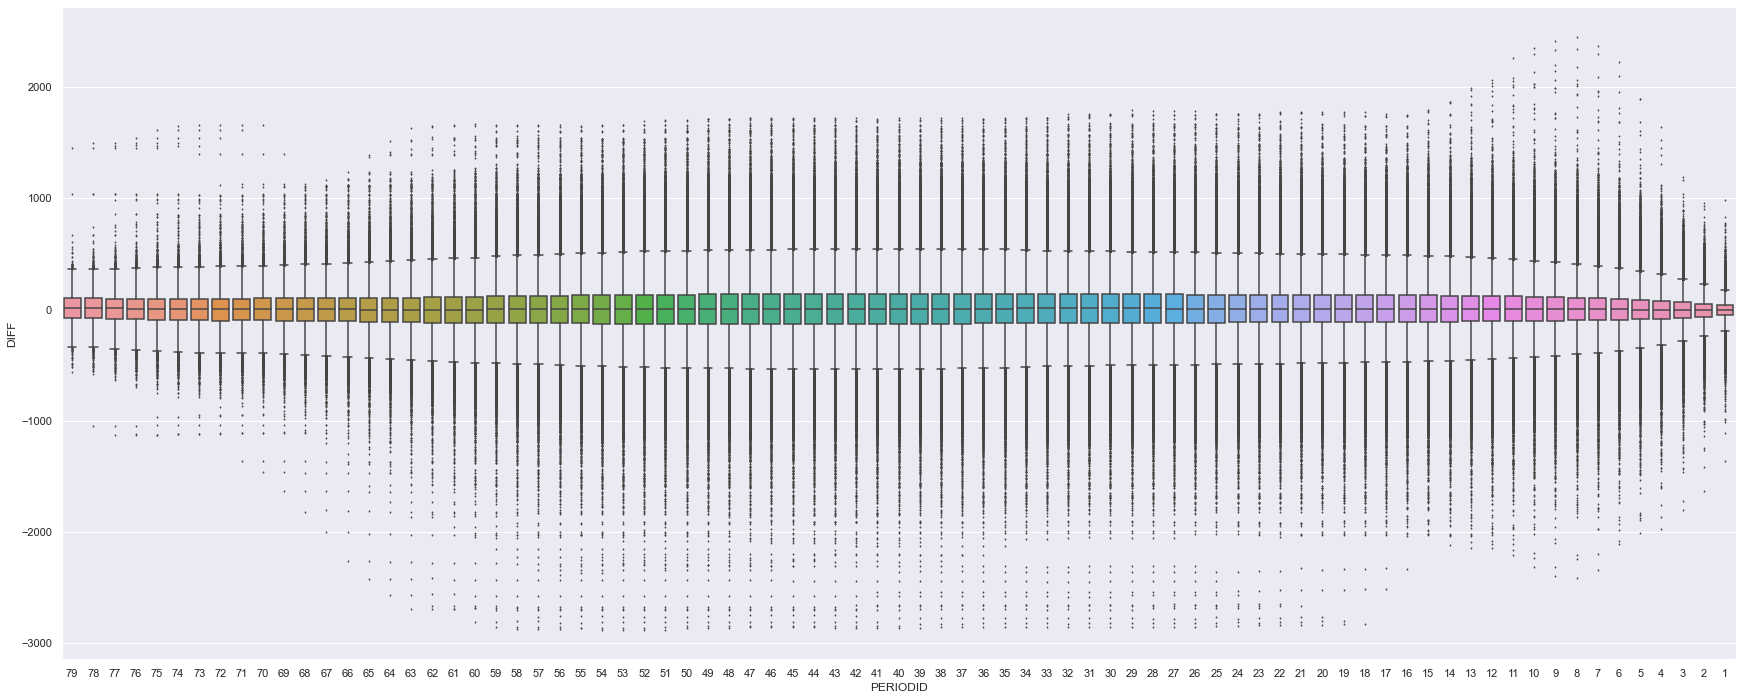

In [20]:

sns.set(rc={"figure.figsize": (30,12)})

# Plot for NSW
# Default for the Seaborn boxplot is whiskers set to 1.5x interquartile range
ordering = list(range(79,0,-1))
sns.boxplot(data = merged[merged['STATE'] == 'NSW'], x='PERIODID',y='DIFF',order=ordering, whis=1.5,fliersize=1)


Some enormous underforecasts for NSW, particularly in the PERIODID range 14-6. Check what they look like directly

In [21]:
merged[(merged['STATE'] == 'NSW') & (merged['DIFF'] > 2000)]['DATETIME'].dt.date.unique().size

2

<AxesSubplot:xlabel='PERIODID', ylabel='DIFF'>

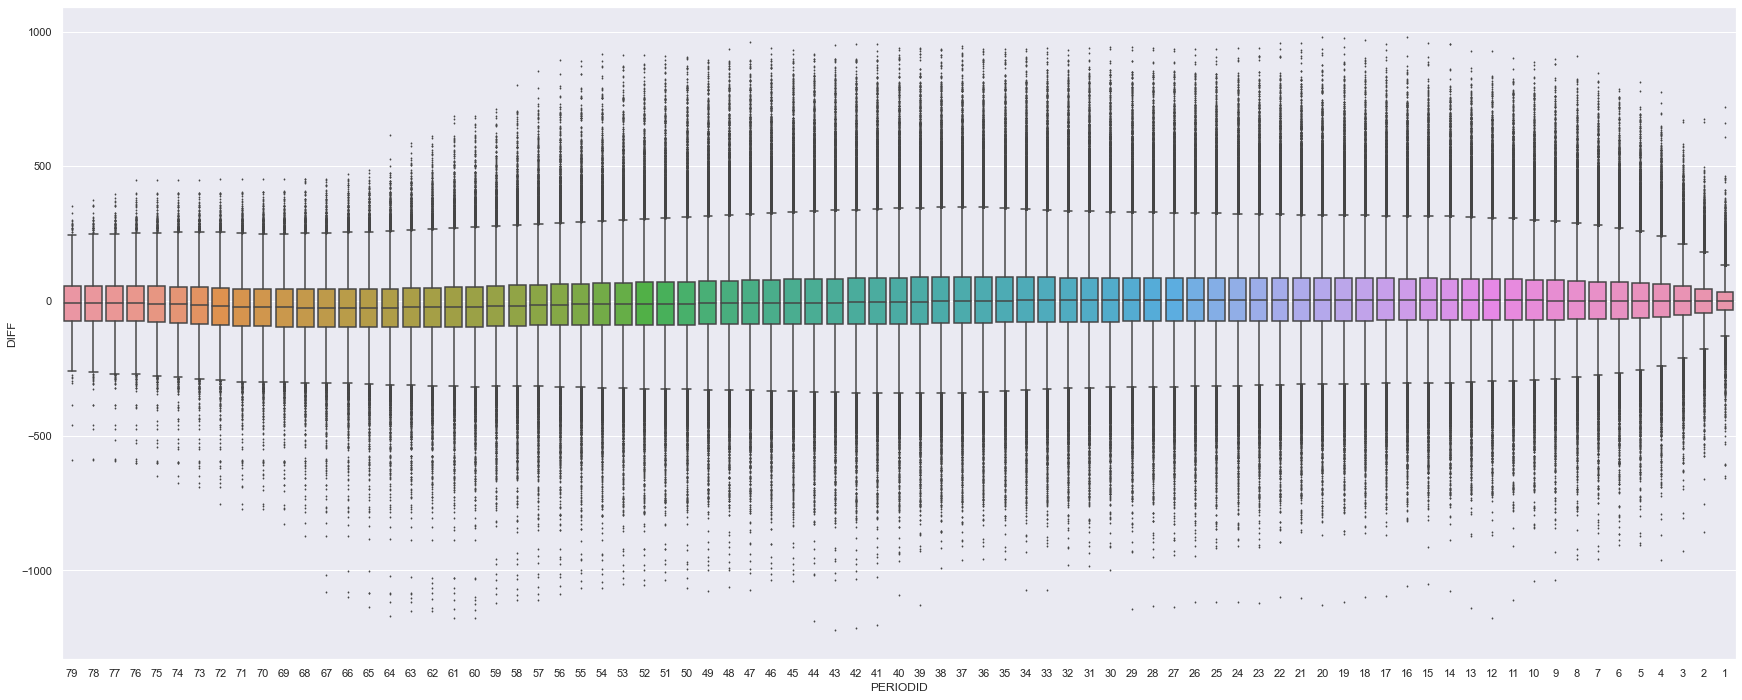

In [22]:
sns.set(rc={"figure.figsize": (30,12)})

# Plot for QLD
# Default for the Seaborn boxplot is whiskers set to 1.5x interquartile range
ordering = list(range(79,0,-1))
sns.boxplot(data = merged[merged['STATE'] == 'QLD'], x='PERIODID',y='DIFF',order=ordering, whis=1.5,fliersize=1)


In [23]:
# Retrieve the outlier forecasts visualised on the boxplot (ie: those greater than 1.5x the IQR)

# Calculate IQRs for each grouped PERIODID for each state

quartiles = pd.DataFrame(columns=['Q1','Q3','IQR'])

quartiles['Q1'] = merged.groupby(['PERIODID','STATE'])['DIFF'].quantile(0.25)
quartiles['Q3'] = merged.groupby(['PERIODID','STATE'])['DIFF'].quantile(0.75)
quartiles['IQR'] = quartiles['Q3'] - quartiles['Q1']

#q1= merged.groupby(['PERIODID'])['DIFF'].quantile(0.25)
#q3 = merged.groupby(['PERIODID'])['DIFF'].quantile(0.75)

#iqr = q3-q1
#iqr
quartiles


Q1        Q3       IQR
PERIODID STATE                             
1        NSW   -55.1400   37.2200   92.3600
         QLD   -32.0400   34.2775   66.3175
         SA    -20.5100   19.1900   39.7000
         VIC   -44.7800   28.0800   72.8600
2        NSW   -66.3500   51.0700  117.4200
...                 ...       ...       ...
78       VIC   -69.7300   81.6900  151.4200
79       NSW   -76.7725  100.5175  177.2900
         QLD   -74.2200   54.9500  129.1700
         SA    -33.9000   39.5000   73.4000
         VIC   -69.6200   81.9900  151.6100

[316 rows x 3 columns]

In [24]:
merged = pd.merge(left=merged, right=quartiles, left_on=['PERIODID','STATE'], right_index=True)

In [25]:
merged.shape
merged.isna().sum()

(23187779, 26)

PREDISPATCHSEQNO           0
PERIODID                   0
FORECASTDEMAND             0
LASTCHANGED                0
DATETIME                   0
STATE                      0
TOTALDEMAND                0
POWER               11394010
LOCATION                   0
TEMPERATURE              414
Weekday                    0
Quarter                    0
Month                      0
Season                     0
Day                        0
Year                       0
SUNRISE                    0
SUNSET                     0
DAYTYPE                    0
HOLIDAY                    0
MEANFORECAST               0
_merge                     0
DIFF                       0
Q1                         0
Q3                         0
IQR                        0
dtype: int64

In [26]:
outliers = merged.query('DIFF <= (Q1 - 1.5 * IQR) or DIFF >= (Q3 + 1.5 * IQR)')

In [27]:
outliers.head(10)

,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME,STATE,TOTALDEMAND,POWER,LOCATION,TEMPERATURE,...,SUNRISE,SUNSET,DAYTYPE,HOLIDAY,MEANFORECAST,_merge,DIFF,Q1,Q3,IQR
23976,2010010818,71,7759.02,2010-01-08 12:31:53,2010-01-10 00:00:00,NSW,8247.43,NaN,Bankstown,24.2,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,7892.487042,both,488.41,-99.73,96.3025,196.0325
24048,2010010819,71,7418.94,2010-01-08 13:01:47,2010-01-10 00:30:00,NSW,7889.17,NaN,Bankstown,23.8,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,7466.909583,both,470.23,-99.73,96.3025,196.0325
24121,2010010820,71,7151.90,2010-01-08 13:31:38,2010-01-10 01:00:00,NSW,7606.72,NaN,Bankstown,23.8,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,7202.441096,both,454.82,-99.73,96.3025,196.0325
24195,2010010821,71,6891.28,2010-01-08 14:01:46,2010-01-10 01:30:00,NSW,7287.96,NaN,Bankstown,23.0,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,6938.060135,both,396.68,-99.73,96.3025,196.0325
24270,2010010822,71,6629.74,2010-01-08 14:31:52,2010-01-10 02:00:00,NSW,7034.07,NaN,Bankstown,22.6,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,6687.802133,both,404.33,-99.73,96.3025,196.0325
24346,2010010823,71,6441.34,2010-01-08 15:01:42,2010-01-10 02:30:00,NSW,6880.65,NaN,Bankstown,22.1,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,6508.839079,both,439.31,-99.73,96.3025,196.0325
24423,2010010824,71,6350.36,2010-01-08 15:31:51,2010-01-10 03:00:00,NSW,6837.91,NaN,Bankstown,23.2,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,6423.084286,both,487.55,-99.73,96.3025,196.0325
24501,2010010825,71,6309.17,2010-01-08 16:01:42,2010-01-10 03:30:00,NSW,6778.70,NaN,Bankstown,23.2,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,6391.098718,both,469.53,-99.73,96.3025,196.0325
24580,2010010826,71,6297.12,2010-01-08 16:31:48,2010-01-10 04:00:00,NSW,6717.56,NaN,Bankstown,23.4,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,6376.083038,both,420.44,-99.73,96.3025,196.0325
29449,2010011020,71,7699.46,2010-01-10 13:31:40,2010-01-12 01:00:00,NSW,8094.42,NaN,Bankstown,23.3,...,2010-01-12 04:58:00,2010-01-12 19:11:00,Night,False,7954.190411,both,394.96,-99.73,96.3025,196.0325


In [28]:
outliers.isna().sum()

PREDISPATCHSEQNO         0
PERIODID                 0
FORECASTDEMAND           0
LASTCHANGED              0
DATETIME                 0
STATE                    0
TOTALDEMAND              0
POWER               535537
LOCATION                 0
TEMPERATURE              0
Weekday                  0
Quarter                  0
Month                    0
Season                   0
Day                      0
Year                     0
SUNRISE                  0
SUNSET                   0
DAYTYPE                  0
HOLIDAY                  0
MEANFORECAST             0
_merge                   0
DIFF                     0
Q1                       0
Q3                       0
IQR                      0
dtype: int64

<AxesSubplot:xlabel='DIFF', ylabel='TEMPERATURE'>

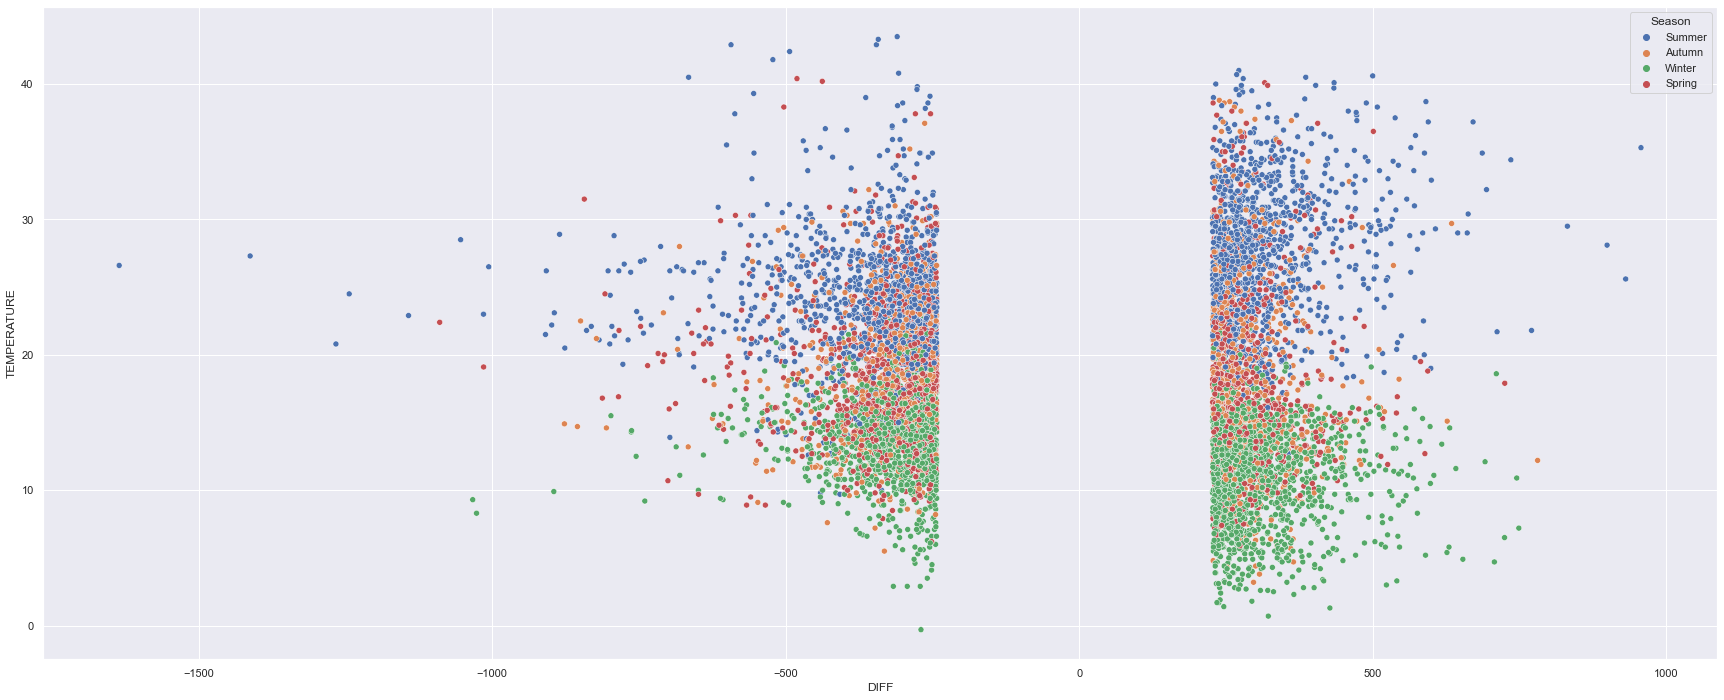

In [86]:
# Plot outliers for NSW according to season
sns.scatterplot(data=outliers[(outliers['STATE'] == 'NSW') & (outliers['PERIODID'] == 2)], x='DIFF',y='TEMPERATURE',hue='Season')

## Distribution of outlier forecasts (for all prediction periods) versus time of day (ie: when are forecasts least reliable?)

### What time of the day do the most mispredictions occur? In what season? In what state?


In [29]:
outliers['TIME'] = outliers['DATETIME'].dt.time

/var/folders/h8/db9ggz8548ddft2yd4yw4kzh0000gq/T/ipykernel_16214/2835706818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['TIME'] = outliers['DATETIME'].dt.time


In [117]:
#outliers[(outliers['STATE'] == 'NSW') & (outliers['PERIODID'] == 48)].groupby(outliers['DATETIME'].dt.time).size()

xdf = outliers[(outliers['STATE'] == 'NSW') & (outliers['PERIODID'] == 48)].groupby(outliers['TIME']).size()

#xdf = outliers[(outliers['STATE'] == 'NSW') & (outliers['PERIODID'] == 48)].groupby(outliers['DATETIME'].dt.time)
#xdf = outliers[(outliers['STATE'] == 'NSW') & (outliers['PERIODID'] == 48)].groupby(outliers['DATETIME'].dt.time)

#xdf.plot(kind='bar')
#sns.histplot(data=xdf, y='TIME')



<AxesSubplot:xlabel='TIME'>

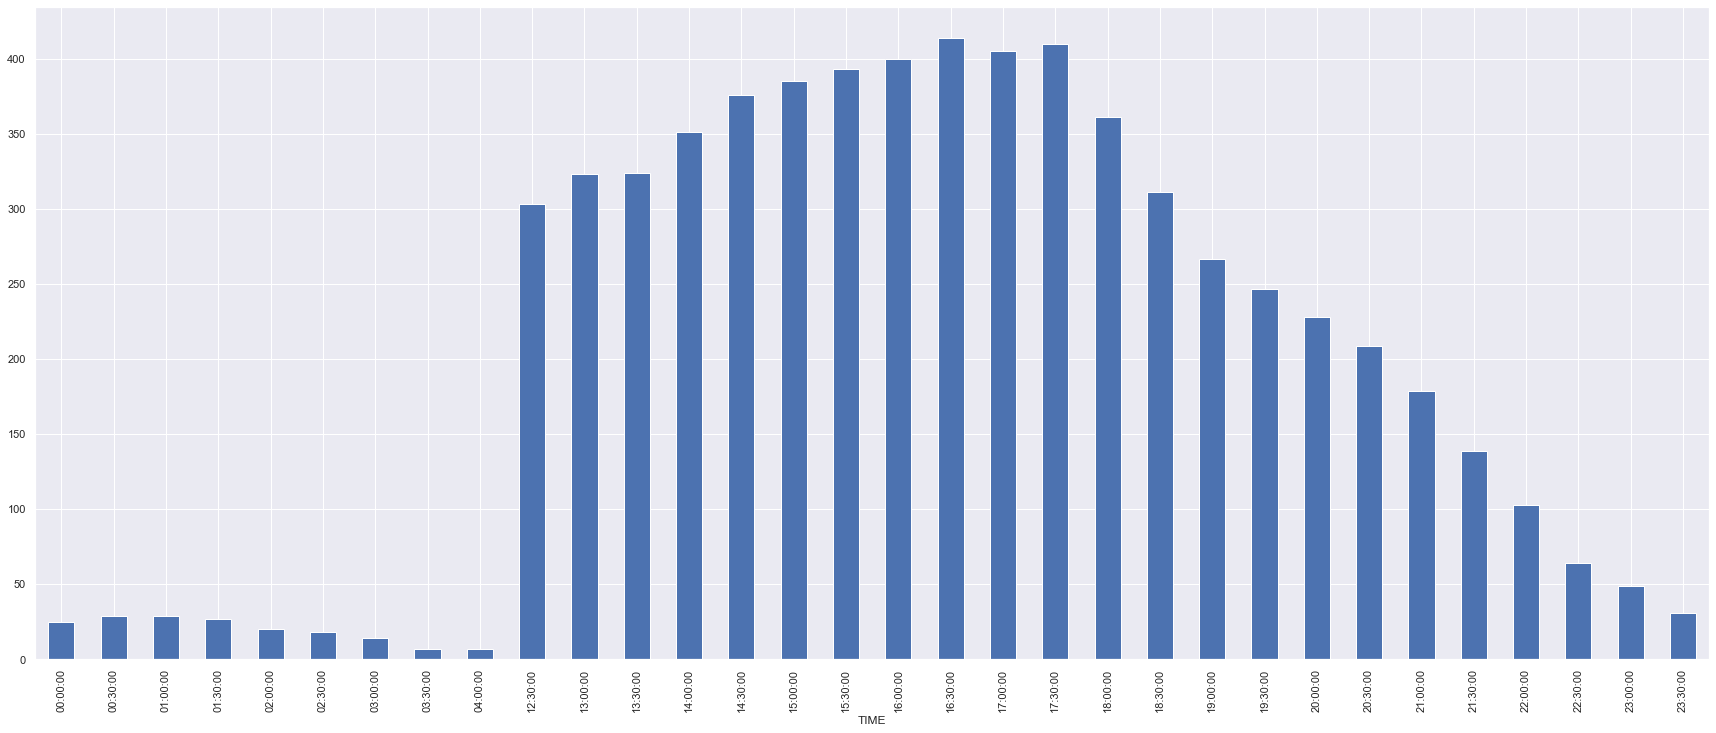

In [118]:
xdf.plot.bar()

In [30]:
# Group the data by TIME and PERIODID and get counts for each combination.
#period_time = outliers[outliers['STATE'] == 'NSW'].groupby(['TIME','PERIODID']).size()
period_time = outliers.groupby(['TIME','PERIODID']).size()

# Pivot into a form compatible with sns.heatmap
pivot_df = period_time.reset_index().pivot(columns='PERIODID',index='TIME')


<AxesSubplot:xlabel='None-PERIODID', ylabel='TIME'>

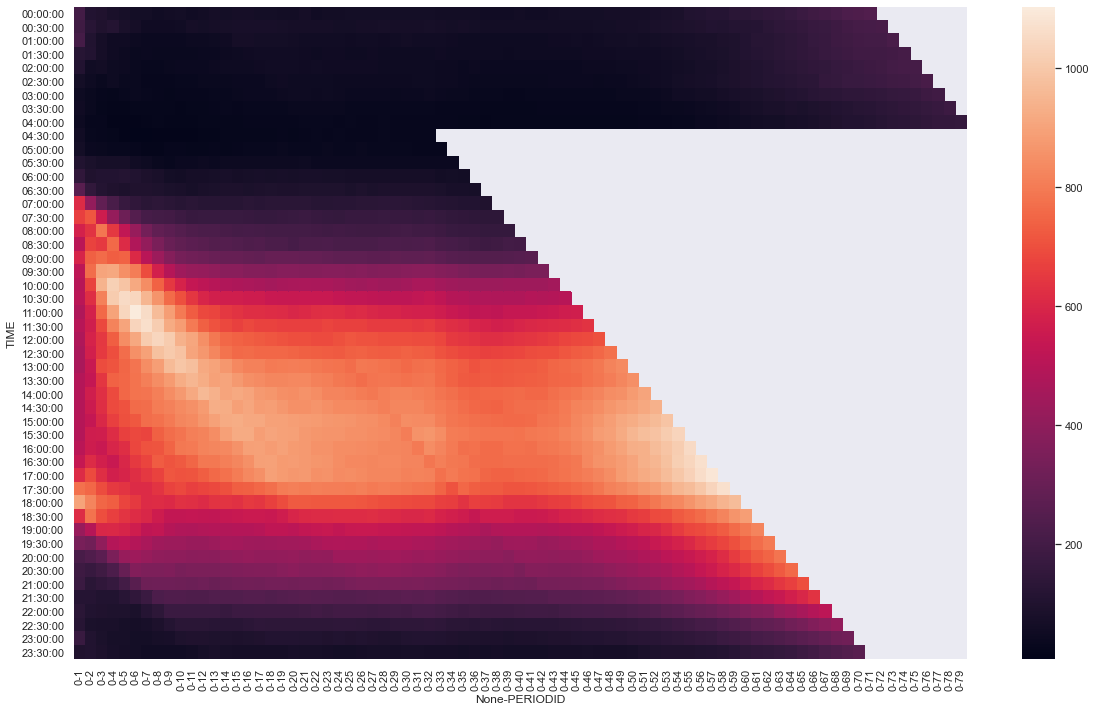

In [32]:
sns.set(rc={"figure.figsize": (20,12)})
sns.heatmap(pivot_df)

<AxesSubplot:xlabel='None-PERIODID', ylabel='TIME'>

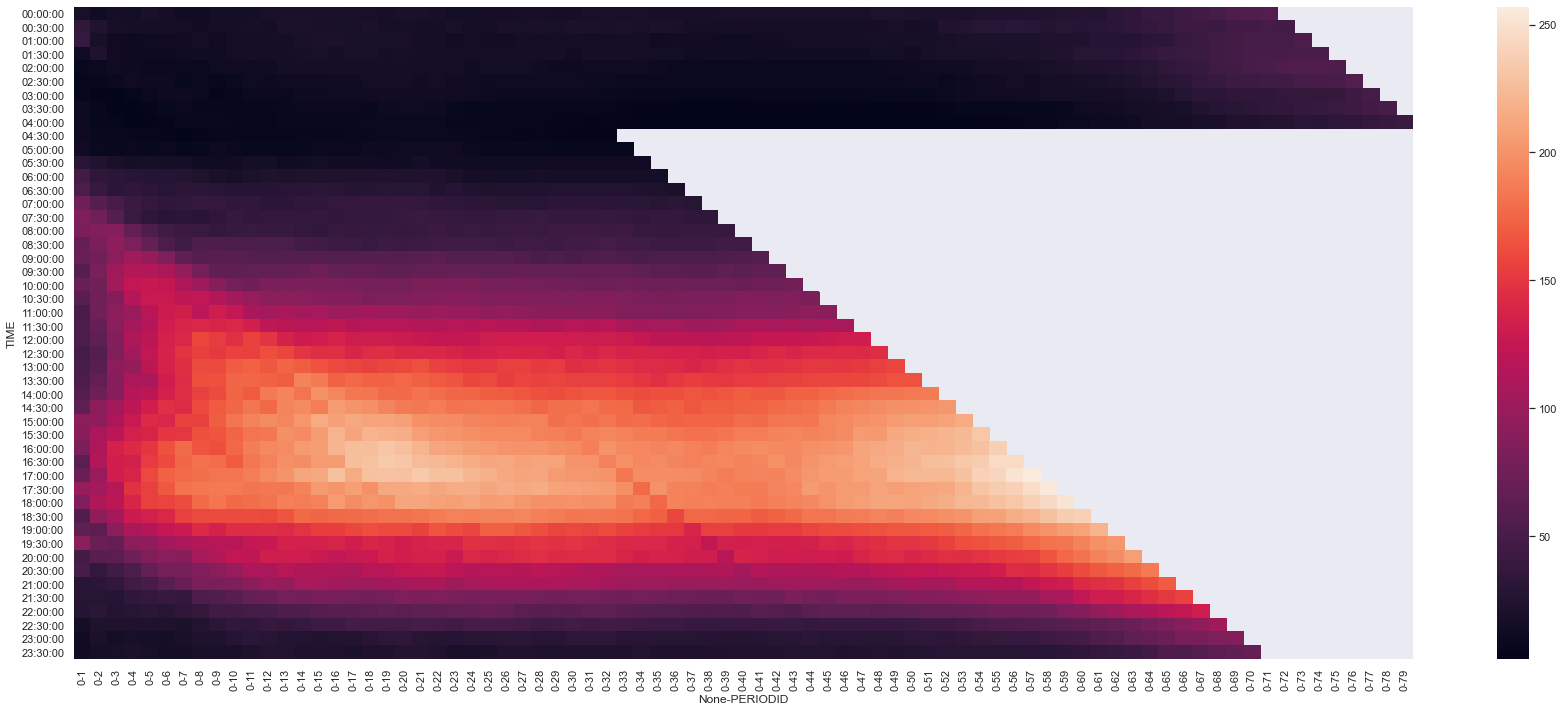

In [80]:
# Group the data by TIME and PERIODID and get counts for each combination.
period_time = outliers[(outliers['STATE'] == 'NSW') & (outliers['Season'] == 'Summer')].groupby(['TIME','PERIODID']).size()

# Pivot into a form compatible with sns.heatmap
pivot_df = period_time.reset_index().pivot(columns='PERIODID',index='TIME')
sns.heatmap(pivot_df)

<AxesSubplot:xlabel='None-PERIODID', ylabel='TIME'>

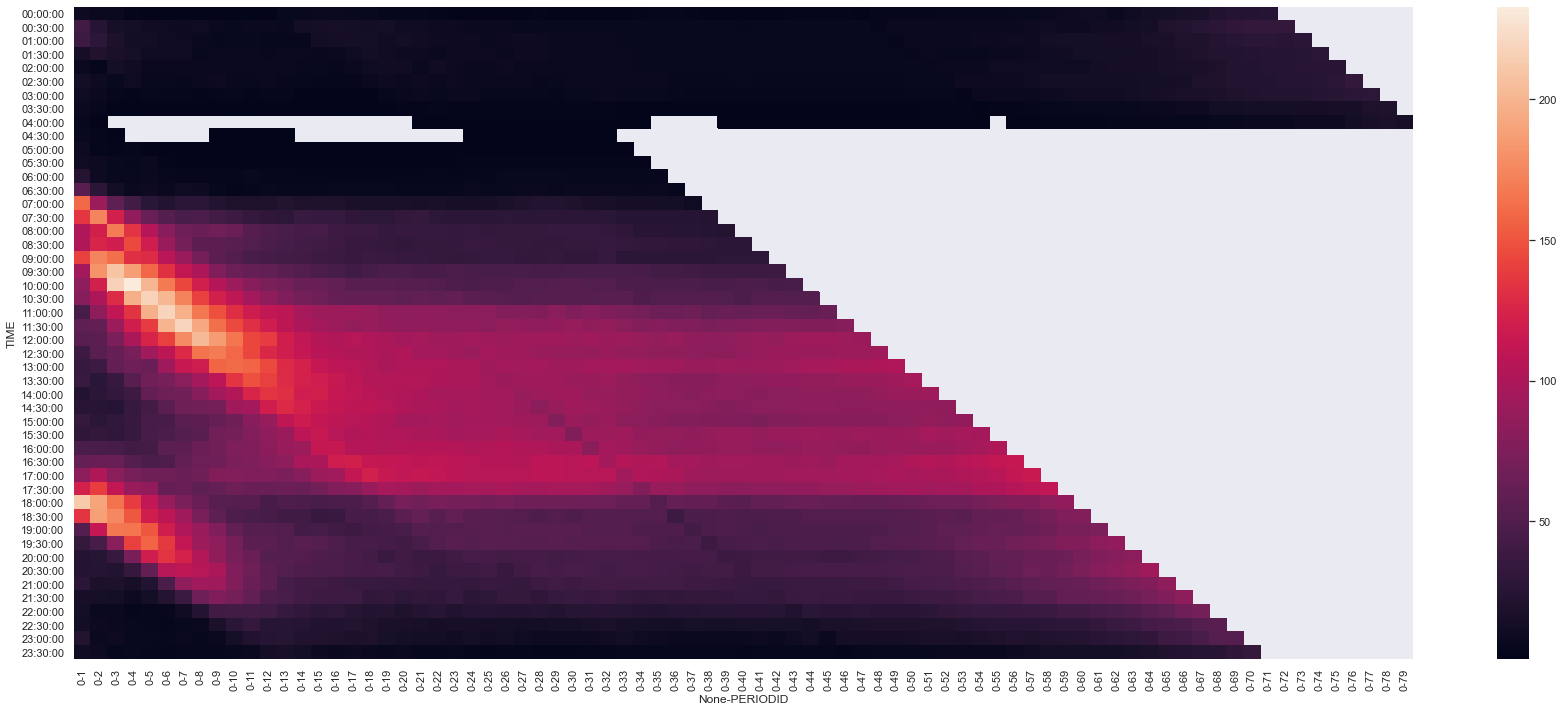

In [81]:
# Group the data by TIME and PERIODID and get counts for each combination.
period_time = outliers[(outliers['STATE'] == 'NSW') & (outliers['Season'] == 'Winter')].groupby(['TIME','PERIODID']).size()

# Pivot into a form compatible with sns.heatmap
pivot_df = period_time.reset_index().pivot(columns='PERIODID',index='TIME')
sns.heatmap(pivot_df)

In [219]:
# Covariance calculations for DIFF, TEMP, POWER for PERIODID = 2 (1 hour ahead forecast)
cov_df = merged[(merged['PERIODID'] == 2)]
cov_df = cov_df.set_index('DATETIME')

In [217]:
cov_df = cov_df.dropna()

In [220]:
cov_df['POWER-1H'] = cov_df['POWER'] - cov_df['POWER'].shift(2)
cov_df['TEMPERATURE-1H'] = cov_df['TEMPERATURE'] - cov_df['TEMPERATURE'].shift(2)

In [182]:
cov_df.head(20)

,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,LASTCHANGED,STATE,TOTALDEMAND,POWER,LOCATION,TEMPERATURE,Weekday,...,DAYTYPE,HOLIDAY,MEANFORECAST,_merge,DIFF,Q1,Q3,IQR,POWER-1H,TEMPERATURE-1H
DATETIME,,,,,,,,,,,,,,,,,,,,,
2018-03-06 09:30:00,2018030610,2,8374.66,2018-03-06 08:31:05,NSW,8325.67,427.281,Bankstown,21.8,Tuesday,...,Day,False,8432.046190,both,-48.99,-66.35,51.07,117.42,NaN,NaN
2018-03-06 10:00:00,2018030611,2,8358.52,2018-03-06 09:00:51,NSW,8338.62,495.195,Bankstown,21.5,Tuesday,...,Day,False,8413.074419,both,-19.90,-66.35,51.07,117.42,NaN,NaN
2018-03-06 10:30:00,2018030612,2,8261.23,2018-03-06 09:30:52,NSW,8323.66,516.137,Bankstown,22.7,Tuesday,...,Day,False,8367.147273,both,62.43,-66.35,51.07,117.42,88.856,0.9
2018-03-06 11:00:00,2018030613,2,8220.58,2018-03-06 10:00:50,NSW,8264.99,549.542,Bankstown,22.1,Tuesday,...,Day,False,8334.082667,both,44.41,-66.35,51.07,117.42,54.347,0.6
2018-03-06 11:30:00,2018030614,2,8214.50,2018-03-06 10:30:49,NSW,8247.11,556.764,Bankstown,22.5,Tuesday,...,Day,False,8289.618478,both,32.61,-66.35,51.07,117.42,40.627,-0.2
2018-03-06 12:00:00,2018030615,2,8249.13,2018-03-06 11:00:59,NSW,8249.70,605.312,Bankstown,23.0,Tuesday,...,Day,False,8272.324894,both,0.57,-66.35,51.07,117.42,55.770,0.9
2018-03-06 12:30:00,2018030616,2,8276.55,2018-03-06 11:30:53,NSW,8201.18,622.850,Bankstown,23.2,Tuesday,...,Day,False,8276.585208,both,-75.37,-66.35,51.07,117.42,66.086,0.7
2018-03-06 13:00:00,2018030617,2,8302.44,2018-03-06 12:00:49,NSW,8184.98,623.553,Bankstown,23.6,Tuesday,...,Day,False,8290.181837,both,-117.46,-66.35,51.07,117.42,18.241,0.6
2018-03-06 13:30:00,2018030618,2,8329.27,2018-03-06 12:31:45,NSW,8175.64,620.090,Bankstown,23.9,Tuesday,...,Day,False,8304.281800,both,-153.63,-66.35,51.07,117.42,-2.760,0.7


In [221]:
# Correlation matrix for DIFF outliers above 1.5 times the interquartile range
cov_df.query('DIFF >= (Q3 + 1.5 * IQR)')[['TOTALDEMAND','POWER','POWER-1H','TEMPERATURE','TEMPERATURE-1H','DIFF']].corr()

#cov_df[cov_df['DIFF'] >= (1.5 * cov_df['IQR'])].corr()

,TOTALDEMAND,POWER,POWER-1H,TEMPERATURE,TEMPERATURE-1H,DIFF
TOTALDEMAND,1.000000,0.145727,-0.138825,-0.145399,-0.062212,0.653772
POWER,0.145727,1.000000,-0.074236,0.475241,0.247928,0.138893
POWER-1H,-0.138825,-0.074236,1.000000,-0.277671,0.461211,-0.117377
TEMPERATURE,-0.145399,0.475241,-0.277671,1.000000,0.078910,-0.139274
TEMPERATURE-1H,-0.062212,0.247928,0.461211,0.078910,1.000000,0.004153
DIFF,0.653772,0.138893,-0.117377,-0.139274,0.004153,1.000000


<AxesSubplot:xlabel='POWER', ylabel='DIFF'>

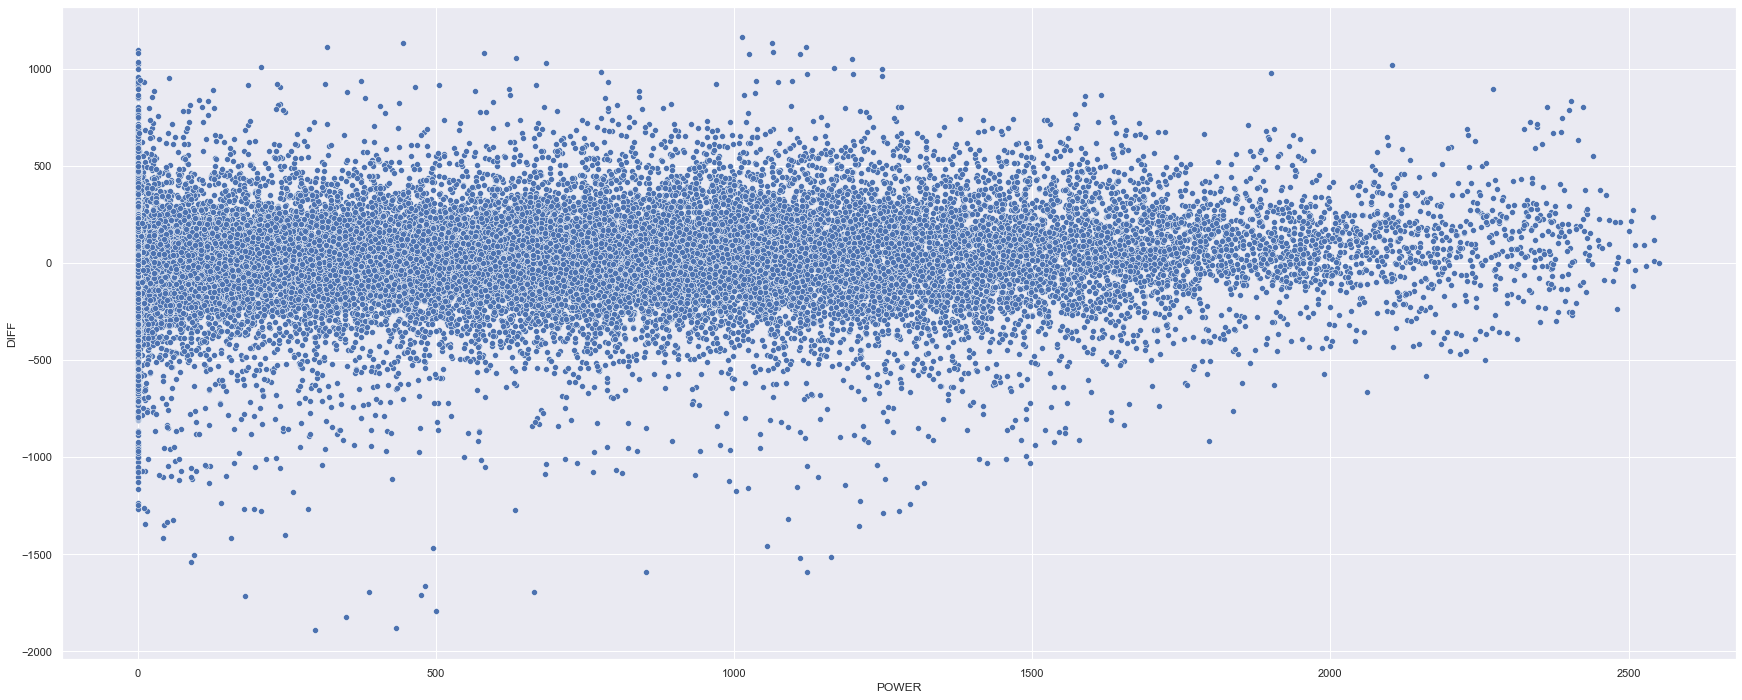

In [218]:
import seaborn as sns
sns.scatterplot(data=cov_df, x='POWER',y='DIFF')